In [1]:
from network import scGen
import scanpy.api as sc
import numpy as np
import wget
from scipy.sparse import csr_matrix


In [2]:
path_to_save = "../results"
sc.settings.figdir = path_to_save

Downloading the train and validation data for Salmonella dataset from Haber et al. dataset and saving them in data folder

In [3]:
train_url = "https://drive.google.com/uc?export=download&id=1U0XLp0X9i73FHJMYOHrlPwWdyaAUFI95"
validation_url = "https://drive.google.com/uc?export=download&id=1vW3r7J1DKYc13S5l4HKG5TaKhNFXcHn1"
t = wget.download(train_url, "../data/train_salmonella.h5ad")
v = wget.download(validation_url, "../data/valid_salmonella.h5ad")



Reading train and validation data

In [3]:
train =  sc.read("../data/train_salmonella.h5ad")
validation = sc.read("../data/valid_salmonella.h5ad")
#training cells
c_in = ['Goblet','Endocrine',"Tuft",'Enterocyte.Progenitor','Stem','Enterocyte', 'TA.Early']
#heldout cells
c_out =  ["TA"]

In [4]:
train.obs["cell_type"] = train.obs["cell_label"]
validation.obs["cell_type"] = validation.obs["cell_label"]
train.X = csr_matrix(train.X)
validation.X = csr_matrix(validation.X)

Lets now make the scGen object with training, validation and condition labels with training and held out cells

In [5]:
scg = scGen(train,validation,{"ctrl":"Control", "stim":"Salmonella"}, c_in, 
            c_out, dr_rate=0.5, model_path= "../models/Salmonella_TA")

we train the model for 150 epochs 

In [6]:
scg.train(150)


----Training----
Model saved in file: ../models/Salmonella_TA
Training finished


Making the prediction for TA cells




In [7]:
pred, delta = scg.predict('TA')


Extracting both control TA cells from the data

In [8]:
adata_list = scg.dr.extractor(train,"TA")

In [21]:
gene_list = ['Reg3b',
 'Reg3g',
 'Apoa1',
 'Guca2b',
 'Zg16',
 'Mt2',
 'Oat',
 'Akr1c13',
 'Otc',
 'Cirbp']

now we interpolate 2000 intermediary cells between control and predicted TA cells and show how
top up and downregulated DE genes change as we move from control to predicted cells 

In [28]:
ctrl = all_Data[all_Data.obs["condition"] == "ctrl"].X
pred_stim = all_Data[all_Data.obs["condition"] == "pred_stim"].X
inter_cdm = sc.AnnData(scg.linear_interploation(ctrl,pred_stim,2000))
inter_cdm.var_names = train.var_names
all_Data = sc.AnnData(np.concatenate([adata_list[1].X.A, pred_stim,inter_cdm.X]),)
all_Data.obs["condition"] = ["ctrl"] * len(adata_list[1].X.A) + ["pred_stim"] * len(pred_stim) + \
                            ["intermediate"] * len( inter_cdm)
all_Data.var_names = adata_list[3].var_names

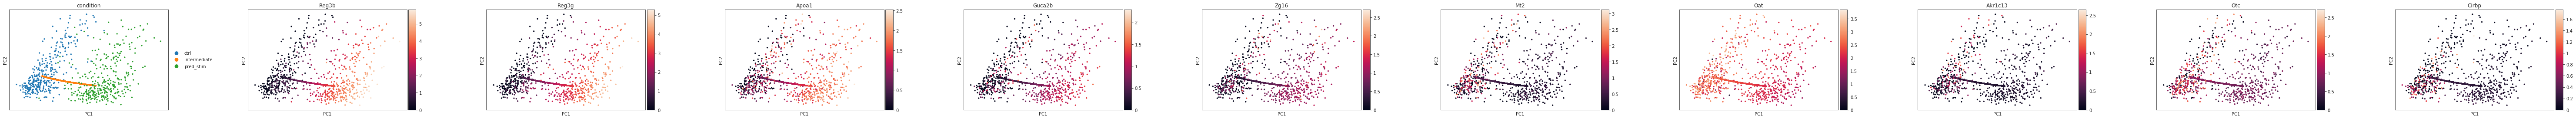

In [32]:
sc.tl.pca(all_Data)
to_show  =  ["condition"] + gene_list
sc.pl.pca(all_Data, color=to_show)
